# Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data cleaning: Nemsis data

In [0]:
nemsis_v2_nat_totals_df = pd.read_csv('gdrive/My Drive/nemsis_v2_national_monthly_totals_edited.csv', thousands=',')
nemsis_v2_reg_totals_df = pd.read_csv('gdrive/My Drive/nemsis_v2_regional_monthly_totals_edited.csv', thousands=',')
nemsis_v3_nat_totals_df = pd.read_csv('gdrive/My Drive/nemsis_v3_national_monthly_totals_edited.csv', thousands=',')
nemsis_v3_reg_totals_df = pd.read_csv('gdrive/My Drive/nemsis_v3_regional_monthly_totals_edited.csv', thousands=',')

In [0]:
nemsis_v3_nat_totals_df = nemsis_v3_nat_totals_df.drop(['Year', 'Month'], axis=1)
nemsis_v3_reg_totals_df = nemsis_v3_reg_totals_df.drop(['Year', 'Month'], axis=1)

In [0]:
nemsis_v3_nat_totals_df = nemsis_v3_nat_totals_df.rename(columns={"Date": "Month"})
nemsis_v3_reg_totals_df = nemsis_v3_reg_totals_df.rename(columns={"Date": "Month", "Geographic Region of Incident.US Census Regions": "Region"})

In [0]:
nemsis_v3_reg_totals_df = nemsis_v3_reg_totals_df.rename(columns={"Census Region": "Region"})

In [0]:
nemsis_v2_reg_totals_df = nemsis_v2_reg_totals_df.rename(columns={"Census Region": "Region"})

In [0]:
nemsis_nat_totals_df = nemsis_v2_nat_totals_df.append(nemsis_v3_nat_totals_df)
nemsis_reg_totals_df = nemsis_v2_reg_totals_df.append(nemsis_v3_reg_totals_df)

In [0]:
nemsis_nat_totals_df.to_csv('nemsis_v2v3_national_monthly_totals.csv')
nemsis_reg_totals_df.to_csv('nemsis_v2v3_regional_monthly_totals.csv')

In [0]:
nemsis_nat_totals_df.head()

,Month,Count of Events
0,1/1/2014,2243815
1,2/1/2014,1987887
2,3/1/2014,2015797
3,4/1/2014,2020800
4,5/1/2014,2313754


In [0]:
nemsis_nat_totals_df[["Month"]] = nemsis_nat_totals_df[["Month"]].apply(pd.to_datetime)
nemsis_reg_totals_df[["Month"]] = nemsis_reg_totals_df[["Month"]].apply(pd.to_datetime)

In [0]:
nemsis_nat_totals_df = nemsis_nat_totals_df.rename(columns={"Count of Events": "Total Events"})
nemsis_reg_totals_df = nemsis_reg_totals_df.rename(columns={"Count of Events": "Total Events"})

In [0]:
nemsis_nat_med_df = pd.read_csv('gdrive/My Drive/nemsis_v2v3_monthly_medication.csv', thousands=',')
nemsis_reg_med_df = pd.read_csv('gdrive/My Drive/nemsis_v2v3_monthly_reg_medication.csv', thousands=',')
nemsis_nat_icd_df = pd.read_csv('gdrive/My Drive/nemsis_v2v3_monthly_icd.csv', thousands=',')
nemsis_reg_icd_df = pd.read_csv('gdrive/My Drive/nemsis_v2v3_monthly_reg_icd.csv', thousands=',')

In [0]:
nemsis_nat_med_df[["Month"]] = nemsis_nat_med_df[["Month"]].apply(pd.to_datetime)
nemsis_reg_med_df[["Month"]] = nemsis_reg_med_df[["Month"]].apply(pd.to_datetime)
nemsis_nat_icd_df[["Month"]] = nemsis_nat_icd_df[["Month"]].apply(pd.to_datetime)
nemsis_reg_icd_df[["Month"]] = nemsis_reg_icd_df[["Month"]].apply(pd.to_datetime)

In [0]:
nemsis_nat_med_df = nemsis_nat_med_df.merge(nemsis_nat_totals_df, how='outer', on='Month')
nemsis_reg_med_df = nemsis_reg_med_df.merge(nemsis_reg_totals_df, how='outer', on=['Month', 'Region'])
nemsis_nat_icd_df = nemsis_nat_icd_df.merge(nemsis_nat_totals_df, how='outer', on='Month')
nemsis_reg_icd_df = nemsis_reg_icd_df.merge(nemsis_reg_totals_df, how='outer', on=['Month', 'Region'])

In [0]:
for df in [nemsis_nat_med_df, nemsis_reg_med_df, nemsis_nat_icd_df, nemsis_reg_icd_df]:
  df[["Count of Events"]] = df[["Count of Events"]].apply(pd.to_numeric)
  df[["Total Events"]] = df[["Total Events"]].apply(pd.to_numeric)
  df['Ratio'] = df['Count of Events'] / df['Total Events']
  df['Ratio_1m'] = df['Count of Events'] / df['Total Events'] * 1000000

In [0]:
for df in [nemsis_nat_med_df, nemsis_reg_med_df, nemsis_nat_icd_df, nemsis_reg_icd_df]:
  df['Ratio_100k'] = df['Count of Events'] / df['Total Events'] * 100000

In [105]:
nemsis_nat_icd_df.tail()

,Month,Count of Events,Total Events,Ratio,Ratio_1m,Ratio_100k
66,2019-07-01,7760,2609045,0.002974,2974.268363,297.426836
67,2019-08-01,7742,2284163,0.003389,3389.425361,338.942536
68,2019-09-01,7061,2063875,0.003421,3421.234329,342.123433
69,2019-10-01,6066,1864195,0.003254,3253.951437,325.395144
70,2019-11-01,6,278207,0.000022,21.566675,2.156668


In [0]:
nemsis_nat_med_df = nemsis_nat_med_df[nemsis_nat_med_df['Month'] < '2019-11-01']
nemsis_nat_icd_df = nemsis_nat_icd_df[nemsis_nat_icd_df['Month'] < '2019-11-01']
nemsis_reg_med_df = nemsis_reg_med_df[nemsis_reg_med_df['Month'] < '2019-11-01']
nemsis_reg_icd_df = nemsis_reg_icd_df[nemsis_reg_icd_df['Month'] < '2019-11-01']

In [0]:
nemsis_reg_med_df = nemsis_reg_med_df.dropna(subset=['Count of Events'])
nemsis_reg_icd_df = nemsis_reg_icd_df.dropna(subset=['Count of Events'])

In [0]:
nemsis_nat_med_df.to_csv('nemsis_national_med_with_ratio.csv')
nemsis_reg_med_df.to_csv('nemsis_regional_med_with_ratio.csv')
nemsis_nat_icd_df.to_csv('nemsis_national_icd_with_ratio.csv')
nemsis_reg_icd_df.to_csv('nemsis_regional_icd_with_ratio.csv')

# Data cleaning: CDC data

In [0]:
cdc_df = pd.read_csv('gdrive/My Drive/cdc_opioids_region_clean.csv')

In [13]:
cdc_df.head()

,Census Region,Month,Month Code,Deaths
0,Census Region 1: Northeast,"Jan., 2014",2014/01,894
1,Census Region 1: Northeast,"Feb., 2014",2014/02,793
2,Census Region 1: Northeast,"Mar., 2014",2014/03,872
3,Census Region 1: Northeast,"Apr., 2014",2014/04,751
4,Census Region 1: Northeast,"May, 2014",2014/05,849


In [0]:
cdc_df['Census Region'] = np.where(cdc_df['Census Region']!='United States', cdc_df['Census Region'].str[17:], cdc_df['Census Region'])

In [0]:
cdc_df[["Month"]] = cdc_df[["Month Code"]].apply(pd.to_datetime)

In [0]:
cdc_df = cdc_df.drop('Month Code', axis=1)

In [0]:
cdc_df.to_csv('cdc_opioid_region_clean.csv')

# Data cleaning: CDC provisional

In [0]:
cdc_prov_df = pd.read_csv('gdrive/My Drive/cdc-prov-by-region.csv', usecols=['REGION', 'Date', 'Deaths'],
                          parse_dates=['Date'])

In [0]:
cdc_prov_df = cdc_prov_df.rename(columns={"Date": "Month"})
cdc_prov_df = cdc_prov_df.rename(columns={"REGION": "Census Region"})

In [0]:
cdc_prov_df = cdc_prov_df[cdc_prov_df['Month'] >= '2018-01-01']

In [0]:
cdc_df = cdc_df.append(cdc_prov_df)

# Nemsis data plots

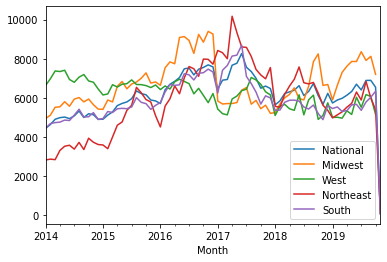

In [0]:
# medication
%matplotlib inline
ax = nemsis_nat_med_df.plot(x='Month', y='Ratio_1m', label='National')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest'].plot(x='Month', y='Ratio_1m', ax=ax, label='Midwest')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West'].plot(x='Month', y='Ratio_1m', ax=ax, label='West')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Northeast'].plot(x='Month', y='Ratio_1m', ax=ax, label='Northeast')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'South'].plot(x='Month', y='Ratio_1m', ax=ax, label='South')

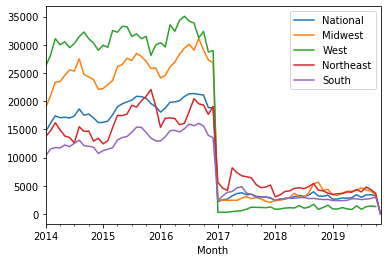

In [0]:
# ICD
%matplotlib inline
ax = nemsis_nat_icd_df.plot(x='Month', y='Ratio_1m', label='National')
nemsis_reg_icd_df[nemsis_reg_icd_df.Region == 'Midwest'].plot(x='Month', y='Ratio_1m', ax=ax, label='Midwest')
nemsis_reg_icd_df[nemsis_reg_icd_df.Region == 'West'].plot(x='Month', y='Ratio_1m', ax=ax, label='West')
nemsis_reg_icd_df[nemsis_reg_icd_df.Region == 'Northeast'].plot(x='Month', y='Ratio_1m', ax=ax, label='Northeast')
nemsis_reg_icd_df[nemsis_reg_icd_df.Region == 'South'].plot(x='Month', y='Ratio_1m', ax=ax, label='South')

# CDC data plots

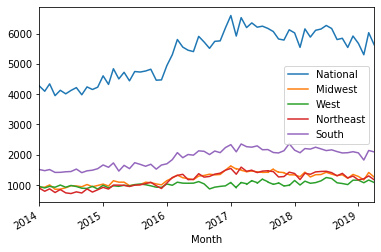

In [22]:
%matplotlib inline
ax = cdc_df[cdc_df['Census Region'] == 'United States'].plot(x='Month', y='Deaths', label='National')
cdc_df[cdc_df['Census Region'] == 'Midwest'].plot(x='Month', y='Deaths', ax=ax, label='Midwest')
cdc_df[cdc_df['Census Region'] == 'West'].plot(x='Month', y='Deaths', ax=ax, label='West')
cdc_df[cdc_df['Census Region'] == 'Northeast'].plot(x='Month', y='Deaths', ax=ax, label='Northeast')
cdc_df[cdc_df['Census Region'] == 'South'].plot(x='Month', y='Deaths', ax=ax, label='South')

# Comparison

In [0]:
# try detrending
# fixed effects model

## Medication: v2/v3

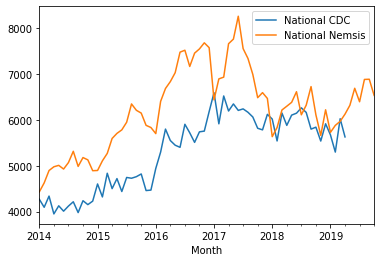

In [191]:
ax = cdc_df[cdc_df['Census Region'] == 'United States'].plot(x='Month', y='Deaths', label='National CDC')
nemsis_nat_med_df.plot(x='Month', y='Ratio_1m', ax=ax, label='National Nemsis')
plt.show()

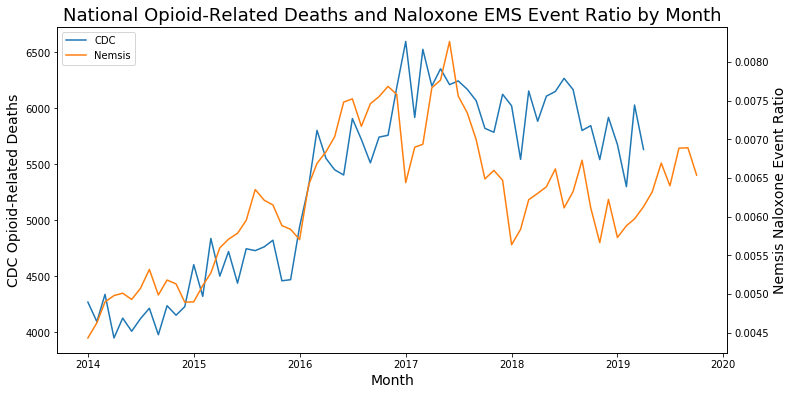

In [234]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df[cdc_df['Census Region'] == 'United States']['Month'],
         cdc_df[cdc_df['Census Region'] == 'United States']['Deaths'], color='C0', label='CDC')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Naloxone Event Ratio', size=14)
ax2.plot(nemsis_nat_med_df['Month'], nemsis_nat_med_df['Ratio'], color='C1', label='Nemsis')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)
ax2.set_title('National Opioid-Related Deaths and Naloxone EMS Event Ratio by Month', size=18)
plt.show()

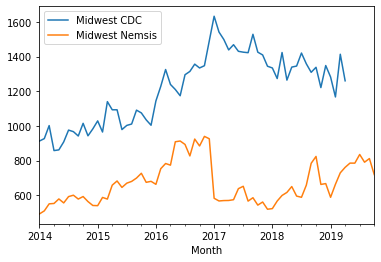

In [190]:
ax = cdc_df[cdc_df['Census Region'] == 'Midwest'].plot(x='Month', y='Deaths', label='Midwest CDC')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest'].plot(x='Month', y='Ratio_100k', ax=ax, label='Midwest Nemsis')

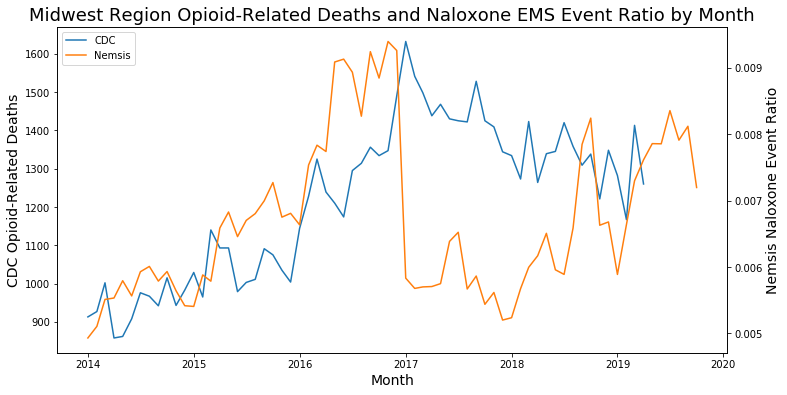

In [239]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df[cdc_df['Census Region'] == 'Midwest']['Month'],
         cdc_df[cdc_df['Census Region'] == 'Midwest']['Deaths'], color='C0', label='CDC')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Naloxone Event Ratio', size=14)
ax2.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest']['Month'],
         nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest']['Ratio'], color='C1', label='Nemsis')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)
ax2.set_title('Midwest Region Opioid-Related Deaths and Naloxone EMS Event Ratio by Month', size=18)
plt.show()

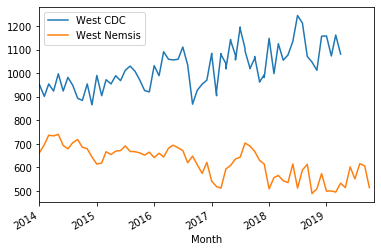

In [39]:
ax = cdc_df[cdc_df['Census Region'] == 'West'].plot(x='Month', y='Deaths', label='West CDC')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West'].plot(x='Month', y='Ratio_100k', ax=ax, label='West Nemsis')

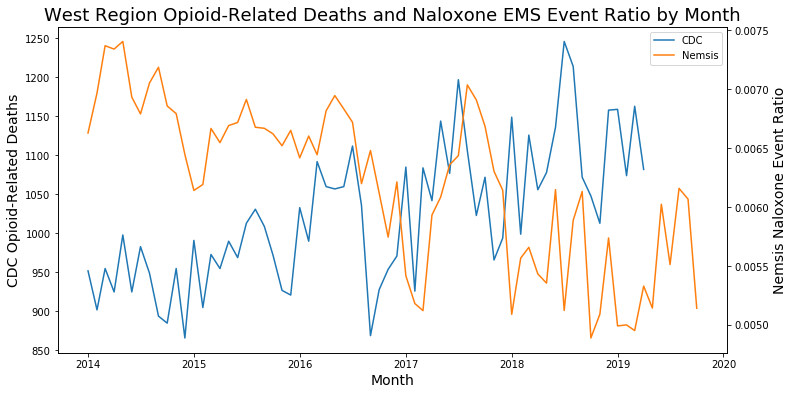

In [241]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df[cdc_df['Census Region'] == 'West']['Month'],
         cdc_df[cdc_df['Census Region'] == 'West']['Deaths'], color='C0', label='CDC')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Naloxone Event Ratio', size=14)
ax2.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West']['Month'],
         nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West']['Ratio'], color='C1', label='Nemsis')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=1)
ax2.set_title('West Region Opioid-Related Deaths and Naloxone EMS Event Ratio by Month', size=18)
plt.show()

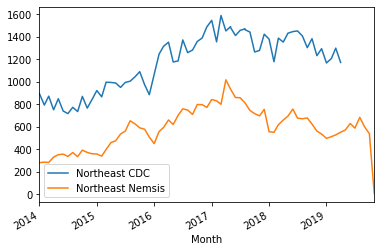

In [40]:
ax = cdc_df[cdc_df['Census Region'] == 'Northeast'].plot(x='Month', y='Deaths', label='Northeast CDC')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Northeast'].plot(x='Month', y='Ratio_100k', ax=ax, label='Northeast Nemsis')

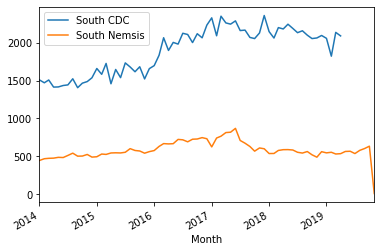

In [41]:
ax = cdc_df[cdc_df['Census Region'] == 'South'].plot(x='Month', y='Deaths', label='South CDC')
nemsis_reg_med_df[nemsis_reg_med_df.Region == 'South'].plot(x='Month', y='Ratio_100k', ax=ax, label='South Nemsis')

In [0]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [0]:
nemsis_nat_med_df_trunc = nemsis_nat_med_df[nemsis_nat_med_df['Month'] <= '2019-04-01']

In [0]:
nemsis_reg_med_df_trunc = nemsis_reg_med_df[nemsis_reg_med_df['Month'] <= '2019-04-01']

In [0]:
xcorr = [crosscorr(
    nemsis_nat_med_df_trunc['Ratio_1m'],
    cdc_df[cdc_df['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]
    
xcorr_midwest = [crosscorr(
    nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'Midwest'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west = [crosscorr(
    nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'West'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast = [crosscorr(
    nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'Northeast'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south = [crosscorr(
    nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'South'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

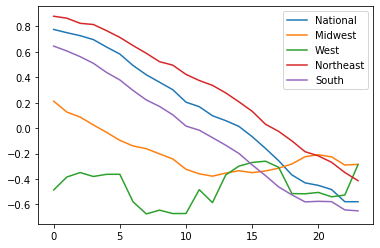

In [151]:
plt.plot(xcorr, label='National')
plt.plot(xcorr_midwest, label='Midwest')
plt.plot(xcorr_west, label='West')
plt.plot(xcorr_northeast, label='Northeast')
plt.plot(xcorr_south, label='South')
plt.legend()

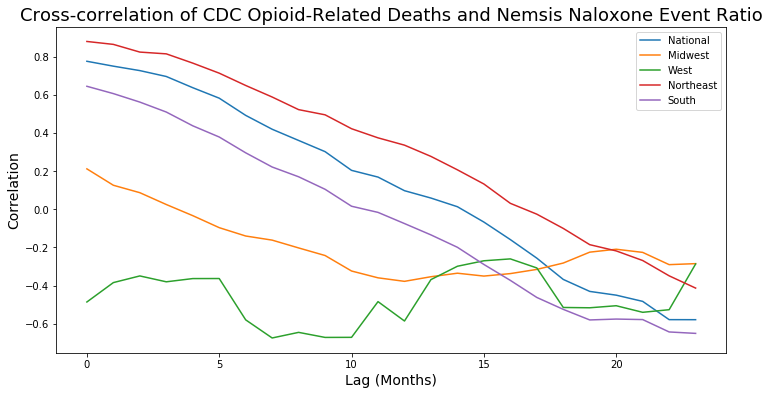

In [237]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(xcorr, label='National')
ax1.plot(xcorr_midwest, label='Midwest')
ax1.plot(xcorr_west, label='West')
ax1.plot(xcorr_northeast, label='Northeast')
ax1.plot(xcorr_south, label='South')
ax1.legend()

ax1.set_xlabel('Lag (Months)', size=14)
ax1.set_ylabel('Correlation', size=14)
ax1.set_title('Cross-correlation of CDC Opioid-Related Deaths and Nemsis Naloxone Event Ratio', size=18)
plt.show()

## Medication: v2/v3 with detrending

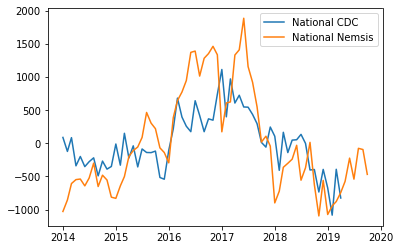

In [117]:
plt.plot(cdc_df[cdc_df['Census Region'] == 'United States']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'United States']['Deaths']), label='National CDC')
plt.plot(nemsis_nat_med_df['Month'], signal.detrend(nemsis_nat_med_df['Ratio_1m']), label='National Nemsis')
plt.legend()
plt.show()

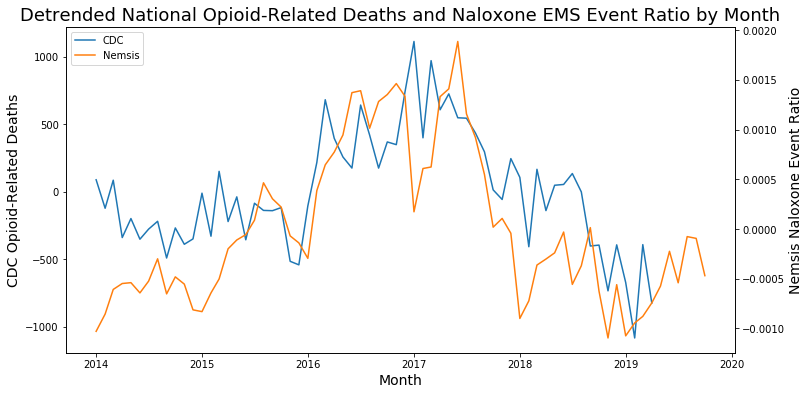

In [233]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df[cdc_df['Census Region'] == 'United States']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'United States']['Deaths']), color='C0', label='CDC')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Naloxone Event Ratio', size=14)
ax2.plot(nemsis_nat_med_df['Month'], signal.detrend(nemsis_nat_med_df['Ratio']), color='C1', label='Nemsis')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)
ax2.set_title('Detrended National Opioid-Related Deaths and Naloxone EMS Event Ratio by Month', size=18)
plt.show()

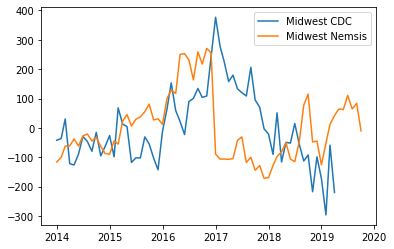

In [142]:
plt.plot(cdc_df[cdc_df['Census Region'] == 'Midwest']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'Midwest']['Deaths']), label='Midwest CDC')
plt.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest']['Month'],
         signal.detrend(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Midwest']['Ratio_100k']), label='Midwest Nemsis')
plt.legend()
plt.show()

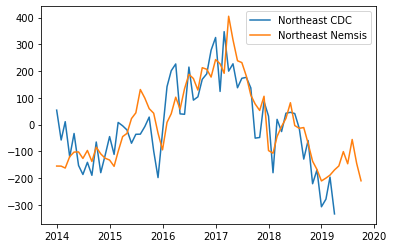

In [143]:
plt.plot(cdc_df[cdc_df['Census Region'] == 'Northeast']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'Northeast']['Deaths']), label='Northeast CDC')
plt.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Northeast']['Month'],
         signal.detrend(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'Northeast']['Ratio_100k']), label='Northeast Nemsis')
plt.legend()
plt.show()

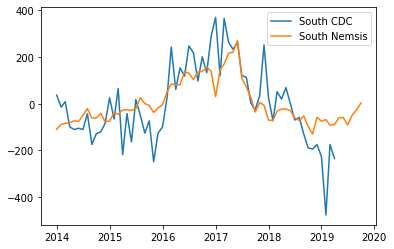

In [144]:
plt.plot(cdc_df[cdc_df['Census Region'] == 'South']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'South']['Deaths']), label='South CDC')
plt.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'South']['Month'],
         signal.detrend(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'South']['Ratio_100k']), label='South Nemsis')
plt.legend()
plt.show()

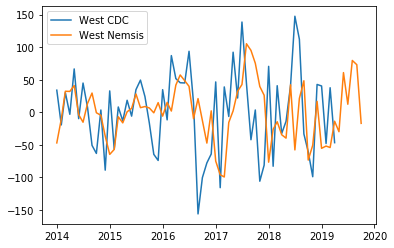

In [145]:
plt.plot(cdc_df[cdc_df['Census Region'] == 'West']['Month'],
         signal.detrend(cdc_df[cdc_df['Census Region'] == 'West']['Deaths']), label='West CDC')
plt.plot(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West']['Month'],
         signal.detrend(nemsis_reg_med_df[nemsis_reg_med_df.Region == 'West']['Ratio_100k']), label='West Nemsis')
plt.legend()
plt.show()

In [0]:
xcorr_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_nat_med_df_trunc['Ratio_1m'])),
    cdc_df[cdc_df['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]
    
xcorr_midwest_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'Midwest'].reset_index()['Ratio_100k'])),
    cdc_df[cdc_df['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'West'].reset_index()['Ratio_100k'])),
    cdc_df[cdc_df['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'Northeast'].reset_index()['Ratio_100k'])),
    cdc_df[cdc_df['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_trunc[nemsis_reg_med_df_trunc['Region'] == 'South'].reset_index()['Ratio_100k'])),
    cdc_df[cdc_df['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

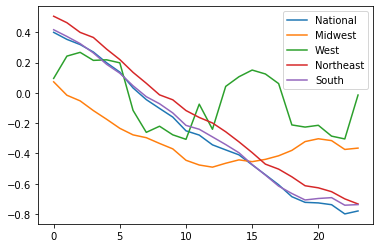

In [153]:
plt.plot(xcorr_dt, label='National')
plt.plot(xcorr_midwest_dt, label='Midwest')
plt.plot(xcorr_west_dt, label='West')
plt.plot(xcorr_northeast_dt, label='Northeast')
plt.plot(xcorr_south_dt, label='South')
plt.legend()

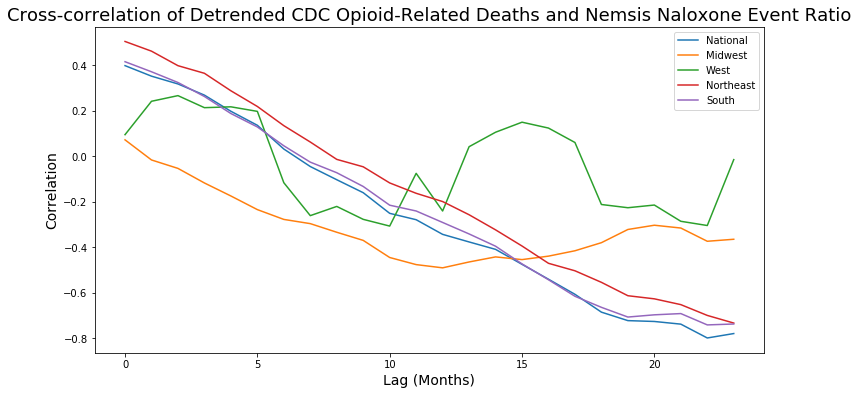

In [238]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(xcorr_dt, label='National')
ax1.plot(xcorr_midwest_dt, label='Midwest')
ax1.plot(xcorr_west_dt, label='West')
ax1.plot(xcorr_northeast_dt, label='Northeast')
ax1.plot(xcorr_south_dt, label='South')
ax1.legend()

ax1.set_xlabel('Lag (Months)', size=14)
ax1.set_ylabel('Correlation', size=14)
ax1.set_title('Cross-correlation of Detrended CDC Opioid-Related Deaths and Nemsis Naloxone Event Ratio', size=18)
plt.show()

## Medication: v2 data only

In [0]:
cdc_df_v2 = cdc_df[cdc_df['Month'] < '2017-01-01']
nemsis_nat_med_df_v2 = nemsis_nat_med_df[nemsis_nat_med_df['Month'] < '2017-01-01']
nemsis_reg_med_df_v2 = nemsis_reg_med_df[nemsis_reg_med_df['Month'] < '2017-01-01']

In [0]:
xcorr_v2 = [crosscorr(
    nemsis_nat_med_df_v2['Ratio_1m'],
    cdc_df_v2[cdc_df_v2['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_midwest_v2 = [crosscorr(
    nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'Midwest'].reset_index()['Ratio_100k'],
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west_v2 = [crosscorr(
    nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'West'].reset_index()['Ratio_100k'],
    cdc_df_v2[cdc_df_v2['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast_v2 = [crosscorr(
    nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'Northeast'].reset_index()['Ratio_100k'],
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south_v2 = [crosscorr(
    nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'South'].reset_index()['Ratio_100k'],
    cdc_df_v2[cdc_df_v2['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

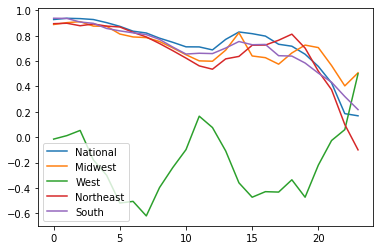

In [134]:
plt.plot(xcorr_v2, label='National')
plt.plot(xcorr_midwest_v2, label='Midwest')
plt.plot(xcorr_west_v2, label='West')
plt.plot(xcorr_northeast_v2, label='Northeast')
plt.plot(xcorr_south_v2, label='South')
plt.legend()

## Medication: v2 data only with detrending

In [0]:
cdc_df_v2 = cdc_df[cdc_df['Month'] < '2017-01-01']
nemsis_nat_med_df_v2 = nemsis_nat_med_df[nemsis_nat_med_df['Month'] < '2017-01-01']
nemsis_reg_med_df_v2 = nemsis_reg_med_df[nemsis_reg_med_df['Month'] < '2017-01-01']

In [0]:
xcorr_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_nat_med_df_v2['Ratio_1m'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_midwest_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'Midwest'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'West'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'Northeast'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v2[nemsis_reg_med_df_v2['Region'] == 'South'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

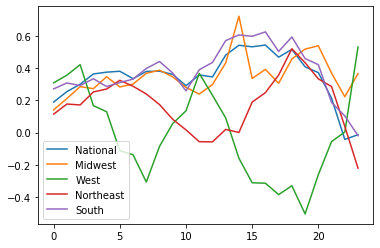

In [132]:
plt.plot(xcorr_v2_dt, label='National')
plt.plot(xcorr_midwest_v2_dt, label='Midwest')
plt.plot(xcorr_west_v2_dt, label='West')
plt.plot(xcorr_northeast_v2_dt, label='Northeast')
plt.plot(xcorr_south_v2_dt, label='South')
plt.legend()

## Medication: v3 data only

In [0]:
cdc_df_v3 = cdc_df[cdc_df['Month'] >= '2017-01-01']

In [0]:
nemsis_nat_med_df_v3 = nemsis_nat_med_df[(nemsis_nat_med_df['Month'] >= '2017-01-01') & (nemsis_nat_med_df['Month'] <= '2019-04-01')]

In [0]:
nemsis_reg_med_df_v3 = nemsis_reg_med_df[(nemsis_reg_med_df['Month'] >= '2017-01-01') & (nemsis_reg_med_df['Month'] <= '2019-04-01')]

In [0]:
xcorr_v3 = [crosscorr(
    nemsis_nat_med_df_v3['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_midwest_v3 = [crosscorr(
    nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'Midwest'].reset_index()['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west_v3 = [crosscorr(
    nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'West'].reset_index()['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast_v3 = [crosscorr(
    nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'Northeast'].reset_index()['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south_v3 = [crosscorr(
    nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'South'].reset_index()['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

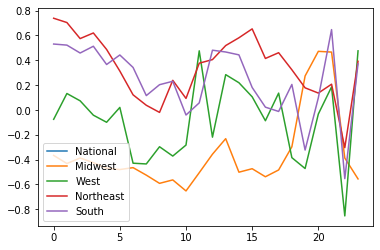

In [96]:
plt.plot(xcorr_v3, label='National')
plt.plot(xcorr_midwest_v3, label='Midwest')
plt.plot(xcorr_west_v3, label='West')
plt.plot(xcorr_northeast_v3, label='Northeast')
plt.plot(xcorr_south_v3, label='South')
plt.legend()

## Medication: v3 data only with detrending

In [0]:
xcorr_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_nat_med_df_v3['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_midwest_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'Midwest'].reset_index()['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_west_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'West'].reset_index()['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_northeast_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'Northeast'].reset_index()['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_south_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_med_df_v3[nemsis_reg_med_df_v3['Region'] == 'South'].reset_index()['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

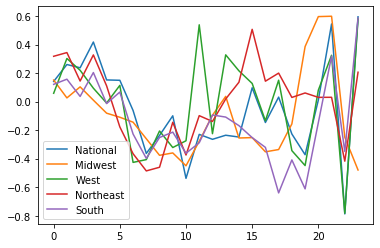

In [137]:
plt.plot(xcorr_v3_dt, label='National')
plt.plot(xcorr_midwest_v3_dt, label='Midwest')
plt.plot(xcorr_west_v3_dt, label='West')
plt.plot(xcorr_northeast_v3_dt, label='Northeast')
plt.plot(xcorr_south_v3_dt, label='South')
plt.legend()

## ICD: v2

In [0]:
nemsis_nat_icd_df_v2 = nemsis_nat_icd_df[nemsis_nat_icd_df['Month'] < '2017-01-01']
nemsis_reg_icd_df_v2 = nemsis_reg_icd_df[nemsis_reg_icd_df['Month'] < '2017-01-01']

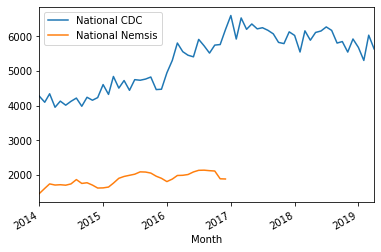

In [48]:
ax = cdc_df[cdc_df['Census Region'] == 'United States'].plot(x='Month', y='Deaths', label='National CDC')
nemsis_nat_icd_df_v2.plot(x='Month', y='Ratio_100k', ax=ax, label='National Nemsis')

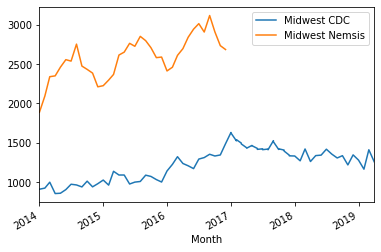

In [49]:
ax = cdc_df[cdc_df['Census Region'] == 'Midwest'].plot(x='Month', y='Deaths', label='Midwest CDC')
nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Midwest'].plot(x='Month', y='Ratio_100k', ax=ax, label='Midwest Nemsis')

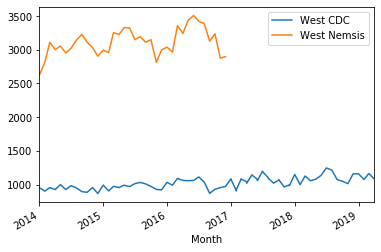

In [50]:
ax = cdc_df[cdc_df['Census Region'] == 'West'].plot(x='Month', y='Deaths', label='West CDC')
nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'West'].plot(x='Month', y='Ratio_100k', ax=ax, label='West Nemsis')

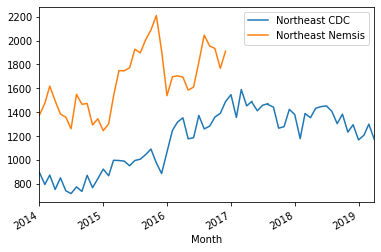

In [51]:
ax = cdc_df[cdc_df['Census Region'] == 'Northeast'].plot(x='Month', y='Deaths', label='Northeast CDC')
nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Northeast'].plot(x='Month', y='Ratio_100k', ax=ax, label='Northeast Nemsis')

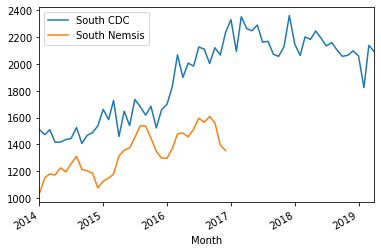

In [52]:
ax = cdc_df[cdc_df['Census Region'] == 'South'].plot(x='Month', y='Deaths', label='South CDC')
nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'South'].plot(x='Month', y='Ratio_100k', ax=ax, label='South Nemsis')

In [0]:
xcorr_icd_v2 = [crosscorr(
    nemsis_nat_icd_df_v2['Ratio_1m'],
    cdc_df[cdc_df['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_midwest_v2 = [crosscorr(
    nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'Midwest'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_west_v2 = [crosscorr(
    nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'West'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_northeast_v2 = [crosscorr(
    nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'Northeast'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_south_v2 = [crosscorr(
    nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'South'].reset_index()['Ratio_100k'],
    cdc_df[cdc_df['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

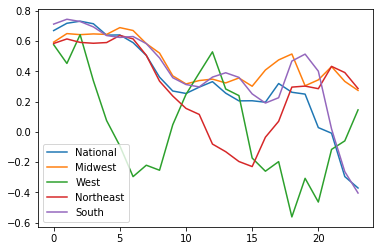

In [160]:
plt.plot(xcorr_icd_v2, label='National')
plt.plot(xcorr_icd_midwest_v2, label='Midwest')
plt.plot(xcorr_icd_west_v2, label='West')
plt.plot(xcorr_icd_northeast_v2, label='Northeast')
plt.plot(xcorr_icd_south_v2, label='South')
plt.legend()

## ICD: v2 with detrending

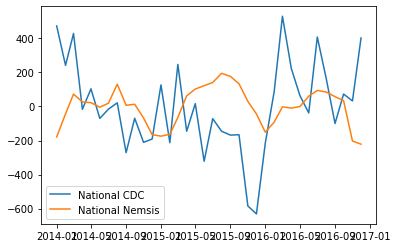

In [141]:
plt.plot(cdc_df_v2[cdc_df_v2['Census Region'] == 'United States']['Month'],
         signal.detrend(cdc_df_v2[cdc_df_v2['Census Region'] == 'United States']['Deaths']), label='National CDC')
plt.plot(nemsis_nat_icd_df_v2['Month'], signal.detrend(nemsis_nat_icd_df_v2['Ratio_100k']), label='National Nemsis')
plt.legend()
plt.show()

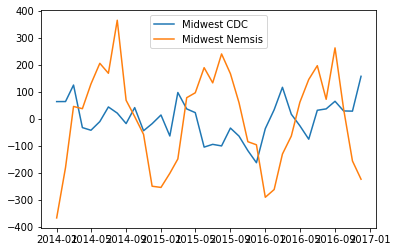

In [154]:
plt.plot(cdc_df_v2[cdc_df_v2['Census Region'] == 'Midwest']['Month'],
         signal.detrend(cdc_df_v2[cdc_df_v2['Census Region'] == 'Midwest']['Deaths']), label='Midwest CDC')
plt.plot(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Midwest']['Month'],
         signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Midwest']['Ratio_100k']), label='Midwest Nemsis')
plt.legend()
plt.show()

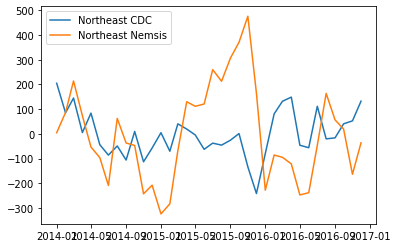

In [155]:
plt.plot(cdc_df_v2[cdc_df_v2['Census Region'] == 'Northeast']['Month'],
         signal.detrend(cdc_df_v2[cdc_df_v2['Census Region'] == 'Northeast']['Deaths']), label='Northeast CDC')
plt.plot(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Northeast']['Month'],
         signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'Northeast']['Ratio_100k']), label='Northeast Nemsis')
plt.legend()
plt.show()

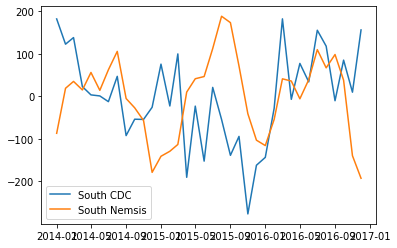

In [156]:
plt.plot(cdc_df_v2[cdc_df_v2['Census Region'] == 'South']['Month'],
         signal.detrend(cdc_df_v2[cdc_df_v2['Census Region'] == 'South']['Deaths']), label='South CDC')
plt.plot(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'South']['Month'],
         signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'South']['Ratio_100k']), label='South Nemsis')
plt.legend()
plt.show()

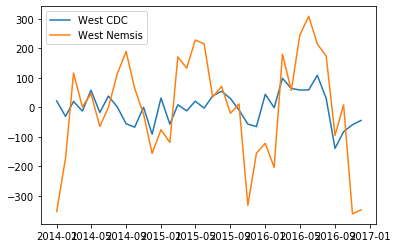

In [157]:
plt.plot(cdc_df_v2[cdc_df_v2['Census Region'] == 'West']['Month'],
         signal.detrend(cdc_df_v2[cdc_df_v2['Census Region'] == 'West']['Deaths']), label='West CDC')
plt.plot(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'West']['Month'],
         signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2.Region == 'West']['Ratio_100k']), label='West Nemsis')
plt.legend()
plt.show()

In [0]:
xcorr_icd_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_nat_icd_df_v2['Ratio_1m'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_midwest_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'Midwest'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_west_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'West'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_northeast_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'Northeast'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_south_v2_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v2[nemsis_reg_icd_df_v2['Region'] == 'South'].reset_index()['Ratio_100k'])),
    cdc_df_v2[cdc_df_v2['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

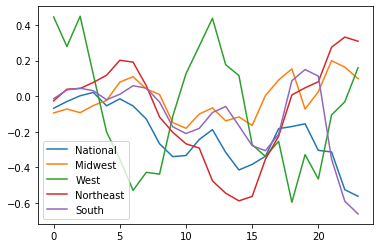

In [182]:
plt.plot(xcorr_icd_v2_dt, label='National')
plt.plot(xcorr_icd_midwest_v2_dt, label='Midwest')
plt.plot(xcorr_icd_west_v2_dt, label='West')
plt.plot(xcorr_icd_northeast_v2_dt, label='Northeast')
plt.plot(xcorr_icd_south_v2_dt, label='South')
plt.legend()

## ICD: v3

In [0]:
nemsis_nat_icd_df_v3 = nemsis_nat_icd_df[nemsis_nat_icd_df['Month'] >= '2017-01-01']
nemsis_reg_icd_df_v3 = nemsis_reg_icd_df[nemsis_reg_icd_df['Month'] >= '2017-01-01']

cdc_df_v3 = cdc_df[cdc_df['Month'] >= '2017-01-01']

In [0]:
nemsis_nat_icd_df_v3_trunc = nemsis_nat_icd_df[(nemsis_nat_icd_df['Month'] >= '2017-01-01') & (nemsis_nat_icd_df['Month'] <= '2019-04-01')]
nemsis_reg_icd_df_v3_trunc = nemsis_reg_icd_df[(nemsis_reg_icd_df['Month'] >= '2017-01-01') & (nemsis_reg_icd_df['Month'] <= '2019-04-01')]

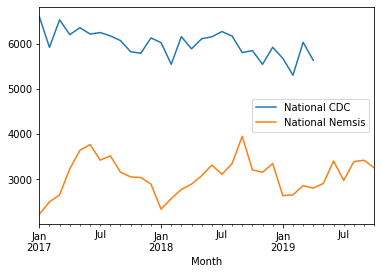

In [166]:
ax = cdc_df_v3[cdc_df_v3['Census Region'] == 'United States'].plot(x='Month', y='Deaths', label='National CDC')
nemsis_nat_icd_df_v3.plot(x='Month', y='Ratio_1m', ax=ax, label='National Nemsis')

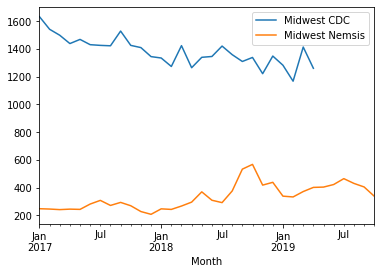

In [171]:
ax = cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest'].plot(x='Month', y='Deaths', label='Midwest CDC')
nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Midwest'].plot(x='Month', y='Ratio_100k', ax=ax, label='Midwest Nemsis')

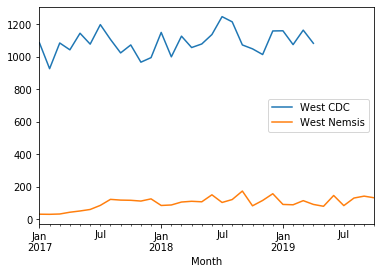

In [172]:
ax = cdc_df_v3[cdc_df_v3['Census Region'] == 'West'].plot(x='Month', y='Deaths', label='West CDC')
nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'West'].plot(x='Month', y='Ratio_100k', ax=ax, label='West Nemsis')

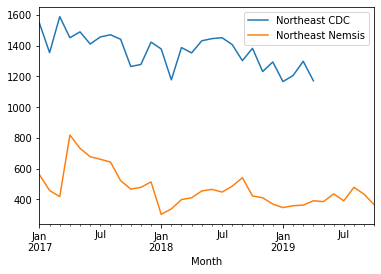

In [170]:
ax = cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast'].plot(x='Month', y='Deaths', label='Northeast CDC')
nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Northeast'].plot(x='Month', y='Ratio_100k', ax=ax, label='Northeast Nemsis')

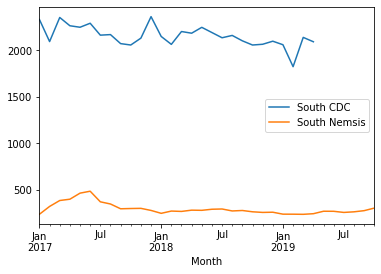

In [173]:
ax = cdc_df_v3[cdc_df_v3['Census Region'] == 'South'].plot(x='Month', y='Deaths', label='South CDC')
nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'South'].plot(x='Month', y='Ratio_100k', ax=ax, label='South Nemsis')

In [0]:
xcorr_icd_v3 = [crosscorr(
    nemsis_nat_icd_df_v3_trunc.reset_index()['Ratio_1m'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(12)]

xcorr_icd_midwest_v3 = [crosscorr(
    nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'Midwest'].reset_index()['Ratio_100k'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(12)]

xcorr_icd_west_v3 = [crosscorr(
    nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'West'].reset_index()['Ratio_100k'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(12)]

xcorr_icd_northeast_v3 = [crosscorr(
    nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'Northeast'].reset_index()['Ratio_100k'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(12)]

xcorr_icd_south_v3 = [crosscorr(
    nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'South'].reset_index()['Ratio_100k'],
    cdc_df_v3[cdc_df_v3['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(12)]

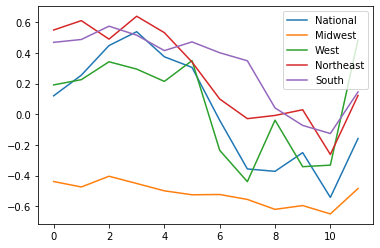

In [246]:
plt.plot(xcorr_icd_v3, label='National')
plt.plot(xcorr_icd_midwest_v3, label='Midwest')
plt.plot(xcorr_icd_west_v3, label='West')
plt.plot(xcorr_icd_northeast_v3, label='Northeast')
plt.plot(xcorr_icd_south_v3, label='South')
plt.legend()

## ICD: v3 with detrending

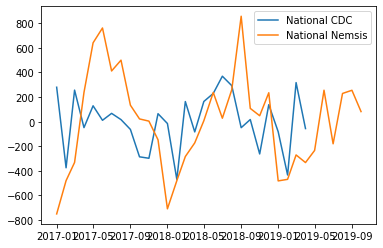

In [176]:
plt.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'United States']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'United States']['Deaths']), label='National CDC')
plt.plot(nemsis_nat_icd_df_v3['Month'], signal.detrend(nemsis_nat_icd_df_v3['Ratio_1m']), label='National Nemsis')
plt.legend()
plt.show()

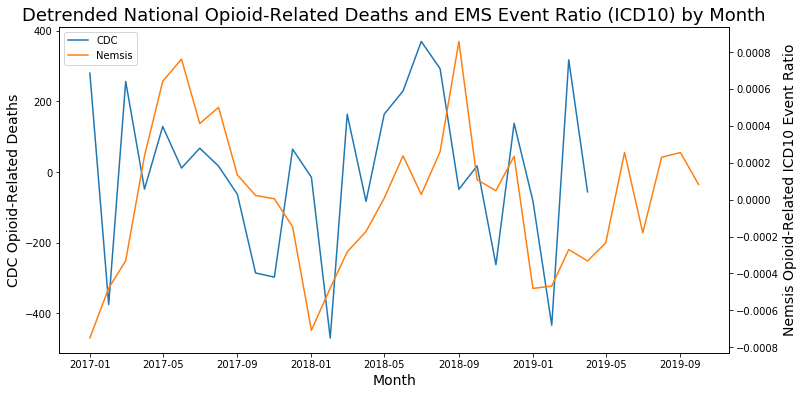

In [242]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'United States']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'United States']['Deaths']), color='C0', label='CDC')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Opioid-Related ICD10 Event Ratio', size=14)
ax2.plot(nemsis_nat_icd_df_v3['Month'], signal.detrend(nemsis_nat_icd_df_v3['Ratio']), color='C1', label='Nemsis')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)
ax2.set_title('Detrended National Opioid-Related Deaths and EMS Event Ratio (ICD10) by Month', size=18)
plt.show()

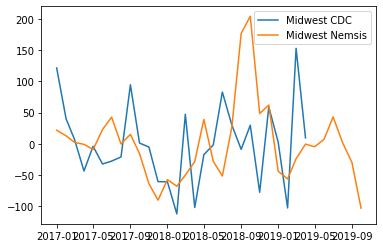

In [177]:
plt.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest']['Deaths']), label='Midwest CDC')
plt.plot(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Midwest']['Month'],
         signal.detrend(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Midwest']['Ratio_100k']), label='Midwest Nemsis')
plt.legend()
plt.show()

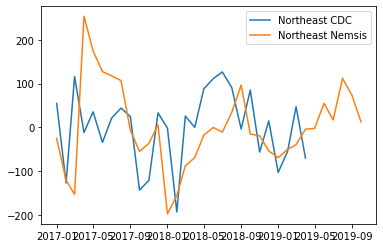

In [178]:
plt.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast']['Deaths']), label='Northeast CDC')
plt.plot(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Northeast']['Month'],
         signal.detrend(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'Northeast']['Ratio_100k']), label='Northeast Nemsis')
plt.legend()
plt.show()

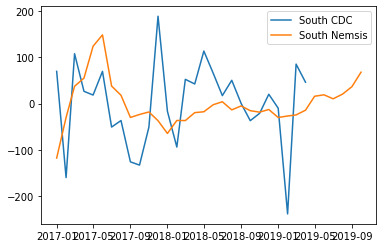

In [179]:
plt.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'South']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'South']['Deaths']), label='South CDC')
plt.plot(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'South']['Month'],
         signal.detrend(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'South']['Ratio_100k']), label='South Nemsis')
plt.legend()
plt.show()

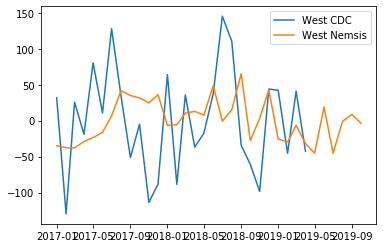

In [180]:
plt.plot(cdc_df_v3[cdc_df_v3['Census Region'] == 'West']['Month'],
         signal.detrend(cdc_df_v3[cdc_df_v3['Census Region'] == 'West']['Deaths']), label='West CDC')
plt.plot(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'West']['Month'],
         signal.detrend(nemsis_reg_icd_df_v3[nemsis_reg_icd_df_v3.Region == 'West']['Ratio_100k']), label='West Nemsis')
plt.legend()
plt.show()

In [0]:
xcorr_icd_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_nat_icd_df_v3_trunc['Ratio_1m'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'United States'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_midwest_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'Midwest'].reset_index()['Ratio_100k'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Midwest'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_west_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'West'].reset_index()['Ratio_100k'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'West'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_northeast_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'Northeast'].reset_index()['Ratio_100k'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'Northeast'].reset_index()['Deaths'], lag=i) for i in range(24)]

xcorr_icd_south_v3_dt = [crosscorr(
    pd.Series(signal.detrend(nemsis_reg_icd_df_v3_trunc[nemsis_reg_icd_df_v3_trunc['Region'] == 'South'].reset_index()['Ratio_100k'])),
    cdc_df_v3[cdc_df_v3['Census Region'] == 'South'].reset_index()['Deaths'], lag=i) for i in range(24)]

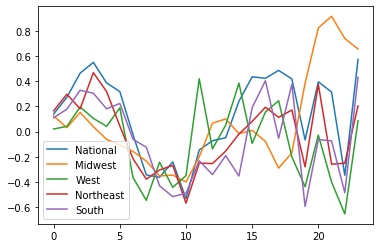

In [248]:
plt.plot(xcorr_icd_v3_dt, label='National')
plt.plot(xcorr_icd_midwest_v3_dt, label='Midwest')
plt.plot(xcorr_icd_west_v3_dt, label='West')
plt.plot(xcorr_icd_northeast_v3_dt, label='Northeast')
plt.plot(xcorr_icd_south_v3_dt, label='South')
plt.legend()

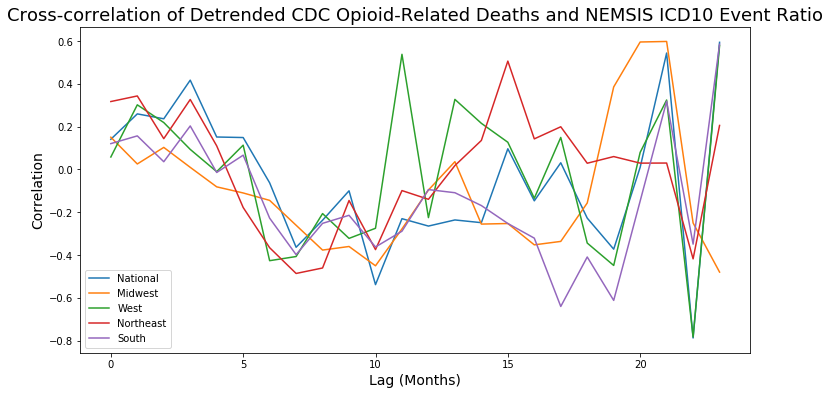

In [250]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(xcorr_v3_dt, label='National')
ax1.plot(xcorr_midwest_v3_dt, label='Midwest')
ax1.plot(xcorr_west_v3_dt, label='West')
ax1.plot(xcorr_northeast_v3_dt, label='Northeast')
ax1.plot(xcorr_south_v3_dt, label='South')
ax1.legend()

ax1.set_xlabel('Lag (Months)', size=14)
ax1.set_ylabel('Correlation', size=14)
ax1.set_title('Cross-correlation of Detrended CDC Opioid-Related Deaths and NEMSIS ICD10 Event Ratio', size=18)
plt.show()

# Models

## Merge dataframes

In [0]:
cdc_df.loc[cdc_df['Census Region'] == 'United States', 'Census Region'] = 'National'

In [0]:
cdc_df[["Month"]] = cdc_df[["Month"]].apply(pd.to_datetime)

In [0]:
nemsis_reg_med_df[["Month"]] = nemsis_reg_med_df[["Month"]].apply(pd.to_datetime)

In [361]:
nemsis_nat_med_df['Region'] = 'National'
nemsis_comb_med_df = nemsis_reg_med_df.append(nemsis_nat_med_df)
nemsis_comb_med_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,Count of Events,Month,Ratio,Ratio_100k,Ratio_1m,Region,Total Events
0,1982.0,2014-01-01,0.004931,493.050770,4930.507703,Midwest,401987.0
1,1425.0,2014-01-01,0.002811,281.073405,2810.734045,Northeast,506985.0
2,4673.0,2014-01-01,0.004440,443.990077,4439.900770,South,1052501.0
3,1.0,2014-01-01,NaN,NaN,NaN,Territories,NaN
4,1859.0,2014-01-01,0.006629,662.898711,6628.987109,West,280435.0


In [0]:
merged_df = nemsis_comb_med_df.merge(cdc_df, how='left', left_on=['Month', 'Region'], right_on=['Month', 'Census Region'])

In [0]:
monthly_events = 25000000 / 12.0
northeast_conv = monthly_events * 0.17
midwest_conv = monthly_events * 0.21
south_conv = monthly_events * 0.38
west_conv = monthly_events * 0.24

In [0]:
merged_df.loc[merged_df['Region'] == 'Northeast', 'Adjusted Count'] = merged_df['Ratio'] * northeast_conv
merged_df.loc[merged_df['Region'] == 'Midwest', 'Adjusted Count'] = merged_df['Ratio'] * midwest_conv
merged_df.loc[merged_df['Region'] == 'South', 'Adjusted Count'] = merged_df['Ratio'] * south_conv
merged_df.loc[merged_df['Region'] == 'West', 'Adjusted Count'] = merged_df['Ratio'] * west_conv
merged_df.loc[merged_df['Region'] == 'National', 'Adjusted Count'] = merged_df['Ratio'] * monthly_events

In [504]:
merged_df.head()

,Count of Events,Month,Ratio,Ratio_100k,Ratio_1m,Region,Total Events,Census Region,Deaths,Adjusted Count
0,1982.0,2014-01-01,0.004931,493.050770,4930.507703,Midwest,401987.0,Midwest,913.0,2157.097120
1,1425.0,2014-01-01,0.002811,281.073405,2810.734045,Northeast,506985.0,Northeast,894.0,995.468308
2,4673.0,2014-01-01,0.004440,443.990077,4439.900770,South,1052501.0,South,1510.0,3514.921443
3,1.0,2014-01-01,NaN,NaN,NaN,Territories,NaN,NaN,NaN,NaN
4,1859.0,2014-01-01,0.006629,662.898711,6628.987109,West,280435.0,West,952.0,3314.493555


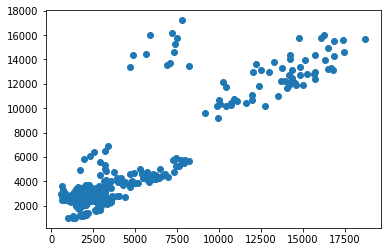

In [505]:
plt.scatter(merged_df['Count of Events'], merged_df['Adjusted Count'])

## Create training data

In [0]:
x_region = {}
y_region = {}
for _, row in merged_df.iterrows():
  if row['Count of Events'] > 50 and row['Deaths'] > 0:
    x_region.setdefault(row['Region'], []).append(row['Adjusted Count'])
    y_region.setdefault(row['Region'], []).append(row['Deaths'])

In [0]:
x = []
y = []
test_x = []
for _, row in merged_df.iterrows():
  if row['Count of Events'] > 50:
    if row['Deaths'] > 0:
      x.append([row['Adjusted Count']])
      y.append(row['Deaths'])
    elif row['Adjusted Count'] > 0:
      test_x.append([row['Adjusted Count']])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [0]:
x_train = np.array(x_train).reshape((-1, 1))
x_test = np.array(x_test).reshape((-1, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
model = LinearRegression().fit(x_train, y_train)

In [0]:
y_pred = model.predict(x_test)

In [512]:
r_sq = model.score(x_train, y_train)
print('train coefficient of determination:', r_sq)
r_sq = model.score(x_test, y_test)
print('test coefficient of determination:', r_sq)

train coefficient of determination: 0.9536477781776662
test coefficient of determination: 0.9616022989680755


In [515]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: 76.2181067553845
slope: [0.39836517]


In [516]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 115820.29
Variance score: 0.96


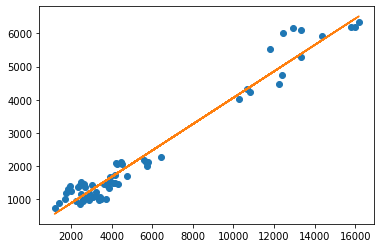

In [517]:
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred, color='C1')

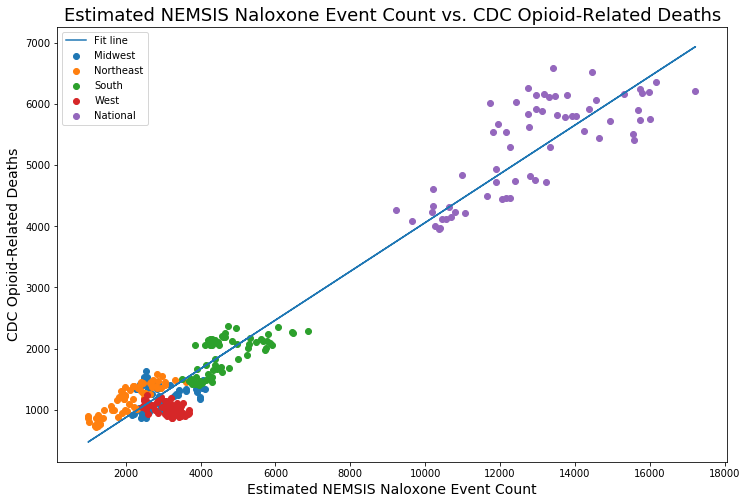

In [518]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel('Estimated NEMSIS Naloxone Event Count', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
for k, v in x_region.items():
  plt.scatter(v, y_region[k], label=k)
ax1.plot(x_train, model.predict(x_train), label='Fit line')
ax1.legend()
ax1.set_title('Estimated NEMSIS Naloxone Event Count vs. CDC Opioid-Related Deaths', size=18)
plt.show()

In [519]:
test_rows = merged_df[merged_df['Adjusted Count'] > 0][pd.isnull(merged_df['Deaths'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
test_rows['Prediction'] = model.predict(np.array(test_rows['Adjusted Count']).reshape(-1, 1))

In [521]:
test_rows.head()

,Count of Events,Month,Ratio,Ratio_100k,Ratio_1m,Region,Total Events,Census Region,Deaths,Adjusted Count,Prediction
317,3217.0,2019-05-01,0.007858,785.822463,7858.224632,Midwest,409380.0,NaN,NaN,3437.973277,1445.786899
318,2010.0,2019-05-01,0.005710,570.972443,5709.724428,Northeast,352031.0,NaN,NaN,2022.194068,881.789781
320,6577.0,2019-05-01,0.005633,563.326478,5633.264784,South,1167529.0,NaN,NaN,4459.667954,1852.794468
322,3453.0,2019-05-01,0.005143,514.303843,5143.038429,West,671393.0,NaN,NaN,2571.519215,1100.621784
323,3137.0,2019-06-01,0.007855,785.536316,7855.363157,Midwest,399345.0,NaN,NaN,3436.721381,1445.288188


In [0]:
last_row = cdc_df[cdc_df['Census Region'] == 'National'].tail(1)

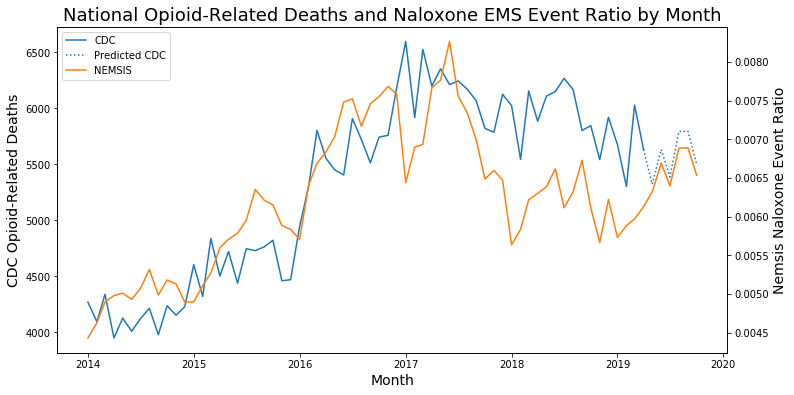

In [523]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month', size=14)
ax1.set_ylabel('CDC Opioid-Related Deaths', size=14)
ax1.plot(cdc_df[cdc_df['Census Region'] == 'National']['Month'],
         cdc_df[cdc_df['Census Region'] == 'National']['Deaths'], color='C0', label='CDC')
ax1.plot(last_row['Month'].append(test_rows[test_rows['Region'] == 'National']['Month']),
         last_row['Deaths'].append(test_rows[test_rows['Region'] == 'National']['Prediction']),
         color='C0', label='Predicted CDC', linestyle=':')

ax2 = ax1.twinx()

ax2.set_ylabel('Nemsis Naloxone Event Ratio', size=14)
ax2.plot(nemsis_nat_med_df['Month'], nemsis_nat_med_df['Ratio'], color='C1', label='NEMSIS')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)
ax2.set_title('National Opioid-Related Deaths and Naloxone EMS Event Ratio by Month', size=18)
plt.show()